<img src="images/nan.jpg" alt="Post NaN Banner" width="650" >

# Background

While working on a health-related classification project we encountered a very large [sparse metrix](https://en.wikipedia.org/wiki/Sparse_matrix), due to the vast amount of health/lab tests that were available. After a meeting with the business domain experts, we understood that our initial data preprocessing for removing missing data (NaN) was faulty.  
In this post, we would like to share the pit-fall that we experienced and share our process for identifying features with missing values related to classification problems.  

# The Pit Fall  
We had over 2K of features across 40K patients. We knew that most of the features had a significant amount of `NaN`s, so we used the common methods - such as  [scikit-learn's VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) and [caret's near zero variance](http://topepo.github.io/caret/pre-processing.html#zero--and-near-zero-variance-predictors) functions to remove features with high `NaN` values.  
We were left with less than 70 features and ran our base model to see if our classifier model could predict better than randomness. After displaying the [feature importance](https://catboost.ai/docs/concepts/python-reference_catboostclassifier_get_feature_importance.html#python-reference_catboostclassifier_get_feature_importance) from our `CatBoost` model, some concerns were raised regarding some of the features.  
So we went back and did some homework...  

While re-analyzing the features that were left, we saw that although they had passed 
our initial `NaN` tests, we did not check for the distribution of the NaN across our classes, i.e. some features had a significant amount of NaNs concentrated in a specific class which were not evenly distributed across our group classifications.

# Data sample  
To demonstrate this process let's look at an example dataset  - the [Horse Colic](https://archive.ics.uci.edu/ml/datasets/Horse+Colic) dataset.  
This dataset includes the outcome/survival of horses diagnosed with colic disease based upon their past medical histories.   

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations

pd.options.display.float_format = "{:,.2f}".format

names = "surgery,Age,Hospital Number,rectal temperature,pulse,respiratory rate,temperature of extremities,peripheral pulse,mucous membranes,capillary refill time,pain,peristalsis,abdominal distension,nasogastric tube,nasogastric reflux,nasogastric reflux PH,rectal examination,abdomen,packed cell volume,total protein,abdominocentesis appearance,abdomcentesis total protein,outcome,surgical lesion,type of lesion1,type of lesion2,type of lesion3,cp_data"
names = names.replace(" ", "_").split(",")
file_path = (
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/horse-colic.csv"
)
df = pd.read_csv(file_path, names=names)
label_col = "outcome"


def preprocess_df(df):
    df.columns = [c.strip() for c in df.columns]
    df = df.replace("?", np.nan).replace("nan", np.nan)
    df = df[~(df["outcome"].isna())].copy()  # clean up label column
    df.index.name = "ID"
    df[label_col] = (
        df[label_col]
        .astype(str)
        .replace({"1": "lived", "2": "died", "3": "euthanized"})
    )
    return df


df = preprocess_df(df)
print(f"df.shape: {df.shape}")
df.head(2)

df.shape: (299, 28)


surgery  Age  Hospital_Number rectal_temperature pulse respiratory_rate  \
ID                                                                           
0        2    1           530101              38.50    66               28   
1        1    1           534817               39.2    88               20   

   temperature_of_extremities peripheral_pulse mucous_membranes  \
ID                                                                
0                           3                3              NaN   
1                         NaN              NaN                4   

   capillary_refill_time  ... packed_cell_volume total_protein  \
ID                        ...                                    
0                      2  ...              45.00          8.40   
1                      1  ...                 50            85   

   abdominocentesis_appearance abdomcentesis_total_protein     outcome  \
ID                                                                       
0                          NaN                         NaN        died   
1                            2                           2  euthanized   

   surgical_lesion type_of_lesion1 type_of_lesion2 type_of_lesion3 cp_data  
ID                                                                          
0                2           11300               0               0       2  
1                2            2208               0               0       2  

[2 rows x 28 columns]

First we will check how many featurs have `NaN` values.

In [2]:
# There are 28 features in this dataset
def number_of_features_with_NaN(df):
    _s_na = df.isna().sum()
    return len(_s_na[_s_na > 0])


print(f"The number features with NaN values are {number_of_features_with_NaN(df)}")

The number features with NaN values are 19



## Near Zero Variance

Simulating our intitial workflow, we will remove features with NaN values with our implementation of caret's R library [near zero variance]("http://topepo.github.io/caret/pre-processing.html#zero--and-near-zero-variance-predictors") function (with their default values). 


In [3]:
def near_zero_variance(df, cols=None, frq_cut=95 / 5, unique_cut=10):
    if not cols:
        cols = df.columns
    drop_cols = []
    for col in cols:
        val_count = list(
            df[col].value_counts(dropna=False, normalize=True).to_dict().items()
        )
        if len(val_count) == 1:
            drop_cols.append(col)
            continue
        lunique = len(val_count)
        percent_unique = 100 * lunique / len(df[col])
        freq_ratio = val_count[0][1] / val_count[1][1] + 1e-5

        if (freq_ratio > frq_cut) & (percent_unique <= unique_cut):
            drop_cols.append(col)
    return df[[c for c in df.columns if c not in drop_cols]]


df_nzr = near_zero_variance(df)
print(
    f"After processeing the dataset via `near_zero_variance` we are left with {number_of_features_with_NaN(df_nzr)} features with NaN values.\n"
)

After processeing the dataset via `near_zero_variance` we are left with 18 features with NaN values.



## Deeper NaN  Analysis
Since we are only interested in understanding the missing values in the dataset, we can view how many `NaN` values are in the various features.
Let's now plot the remaining features relative to the percent of `NaN`s in each feature

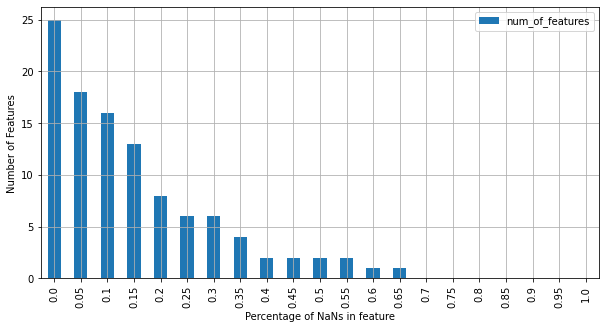

In [4]:
def plot_percent_nan_in_features(df):
    nan = df.isna().sum() / len(df)
    feature_nan_threshold = {
        round(threshold, 2): len(df.columns) - len(nan[nan < threshold])
        for threshold in np.arange(0, 1.01, 0.05)
    }
    _df = pd.DataFrame.from_dict(
        feature_nan_threshold, orient="index", columns=["num_of_features"]
    )
    _df.plot(
        kind="bar",
        ylabel="Number of Features",
        xlabel="Percentage of NaNs in feature",
        figsize=(10, 5),
        grid=True,
    )


plot_percent_nan_in_features(df_nzr)

From the above plot, we can see that the number of features with more than 40% of NaNs are 2 features and above 25% are 6 features.  

We can see that some of the features have very high `NaN` values.  

Let's now remove these problematic features.
For this example we will set a threshold of 35% . 


In [5]:
threshold_max_na = 0.35


def drop_features_above_threshold_max_na(df, threshold_max_na=threshold_max_na):
    nan = df.isna().sum() / len(df)
    nan_threshold = nan[nan > threshold_max_na]
    df = df.drop(columns=nan_threshold.index).copy()
    return df


df_nzr_threshold = drop_features_above_threshold_max_na(df_nzr)
print(
    f"After drop_features_above_threshold_max_na the number of features with NaNs that we are left with are : {number_of_features_with_NaN(df_nzr_threshold)}"
)

After drop_features_above_threshold_max_na the number of features with NaNs that we are left with are : 14


We may assume that we have removed the problematic features and can try to imputate our NaN data and run our pipeline/model.  

But before we do so let's look a bit more closely at our classification. 

## NaN Distribution Among the Classifer Labels 
Looking at the classifier label feature `outcome` we can see the following distribution

In [6]:
def create_value_counts_df(df, s2=pd.Series(dtype=float), col=None, check_na=False):
    if col:
        s1 = df[col].value_counts(dropna=False)
    if check_na:
        s1 = df.isna().sum()
        s2 = df.isna().sum() / len(df)
    if s2.empty:
        s2 = df[col].value_counts(normalize=True, dropna=False)
    df = pd.concat([s1, s2], axis=1)
    df.columns = ["num", "percent"]
    return df.sort_values(by="percent", ascending=False)


df_labels_counts = create_value_counts_df(df, col=label_col)
df_labels_counts

num  percent
lived       178     0.60
died         77     0.26
euthanized   44     0.15

We can see that the distribution of the classes is uneven.    
Our class distribution is apporximately  60%, 25%, 15% between the lived, died, euthanized classes (respectively).   

**But how are our NaNs distributed**?     

What is the distribution of `NaN`s in each feature with relation to our classification field.


In [7]:
def get_na_per_label(df, label_col, labels=df_labels_counts.index):
    cols = [c for c in df.columns if c != label_col]
    sum_na = (
        [df[col].isna().sum()]
        + [
            df[df[label_col] == label][col].isna().sum()
            for label in df_labels_counts.index.tolist()
        ]
        for col in cols
    )
    df_sum_na = pd.DataFrame(
        columns=[f"{col}_sum_na" for col in ["all"] + df_labels_counts.index.tolist()],
        data=sum_na,
        index=cols,
    )
    df_sum_na["all_percentage_na"] = df.isna().sum() / len(df)
    for label in labels:
        df_sum_na[f"{label}_percentage_na"] = (
            df_sum_na[f"{label}_sum_na"] / df_labels_counts.loc[label, "num"]
        )
    return df_sum_na

def get_na_cols(df):
    _s_na = df.isna().sum()
    na_cols = _s_na[_s_na > 0].index
    na_cols = list(na_cols) + [label_col]
    return na_cols

na_cols = get_na_cols(df_nzr_threshold)
df_sum_na = get_na_per_label(df_nzr_threshold[na_cols], label_col)
df_sum_na

all_sum_na  lived_sum_na  died_sum_na  \
rectal_temperature                  60            26           24   
pulse                               24            12           11   
respiratory_rate                    58            31           19   
temperature_of_extremities          56            32           13   
peripheral_pulse                    69            39           18   
mucous_membranes                    47            28           11   
capillary_refill_time               32            19           10   
pain                                55            34           12   
peristalsis                         44            22           15   
abdominal_distension                56            31           14   
nasogastric_tube                   104            62           25   
rectal_examination                 102            56           26   
packed_cell_volume                  29            13            8   
total_protein                       33            13           12   

                            euthanized_sum_na  all_percentage_na  \
rectal_temperature                         10               0.20   
pulse                                       1               0.08   
respiratory_rate                            8               0.19   
temperature_of_extremities                 11               0.19   
peripheral_pulse                           12               0.23   
mucous_membranes                            8               0.16   
capillary_refill_time                       3               0.11   
pain                                        9               0.18   
peristalsis                                 7               0.15   
abdominal_distension                       11               0.19   
nasogastric_tube                           17               0.35   
rectal_examination                         20               0.34   
packed_cell_volume                          8               0.10   
total_protein                               8               0.11   

                            lived_percentage_na  died_percentage_na  \
rectal_temperature                         0.15                0.31   
pulse                                      0.07                0.14   
respiratory_rate                           0.17                0.25   
temperature_of_extremities                 0.18                0.17   
peripheral_pulse                           0.22                0.23   
mucous_membranes                           0.16                0.14   
capillary_refill_time                      0.11                0.13   
pain                                       0.19                0.16   
peristalsis                                0.12                0.19   
abdominal_distension                       0.17                0.18   
nasogastric_tube                           0.35                0.32   
rectal_examination                         0.31                0.34   
packed_cell_volume                         0.07                0.10   
total_protein                              0.07                0.16   

                            euthanized_percentage_na  
rectal_temperature                              0.23  
pulse                                           0.02  
respiratory_rate                                0.18  
temperature_of_extremities                      0.25  
peripheral_pulse                                0.27  
mucous_membranes                                0.18  
capillary_refill_time                           0.07  
pain                                            0.20  
peristalsis                                     0.16  
abdominal_distension                            0.25  
nasogastric_tube                                0.39  
rectal_examination                              0.45  
packed_cell_volume                              0.18  
total_protein                                   0.18

We can see that the distributions of the `NaN`s across the classification field are not even. _e.g._ the `rectal_temperature` feature has twice as much NaN in the `died` & `lived` classes than in the `euthanized` class.  


Assuming that we don't want to remove any features that have less than 15% of `NaN`s, no matter how the `NaN` distribution is across the classification field.

In [8]:
threshold_min_na = 0.15
mask_threshold_min_na = df_sum_na["all_percentage_na"] > threshold_min_na
df_sum_min_na = df_sum_na[mask_threshold_min_na].copy()
df_sum_min_na

all_sum_na  lived_sum_na  died_sum_na  \
rectal_temperature                  60            26           24   
respiratory_rate                    58            31           19   
temperature_of_extremities          56            32           13   
peripheral_pulse                    69            39           18   
mucous_membranes                    47            28           11   
pain                                55            34           12   
abdominal_distension                56            31           14   
nasogastric_tube                   104            62           25   
rectal_examination                 102            56           26   

                            euthanized_sum_na  all_percentage_na  \
rectal_temperature                         10               0.20   
respiratory_rate                            8               0.19   
temperature_of_extremities                 11               0.19   
peripheral_pulse                           12               0.23   
mucous_membranes                            8               0.16   
pain                                        9               0.18   
abdominal_distension                       11               0.19   
nasogastric_tube                           17               0.35   
rectal_examination                         20               0.34   

                            lived_percentage_na  died_percentage_na  \
rectal_temperature                         0.15                0.31   
respiratory_rate                           0.17                0.25   
temperature_of_extremities                 0.18                0.17   
peripheral_pulse                           0.22                0.23   
mucous_membranes                           0.16                0.14   
pain                                       0.19                0.16   
abdominal_distension                       0.17                0.18   
nasogastric_tube                           0.35                0.32   
rectal_examination                         0.31                0.34   

                            euthanized_percentage_na  
rectal_temperature                              0.23  
respiratory_rate                                0.18  
temperature_of_extremities                      0.25  
peripheral_pulse                                0.27  
mucous_membranes                                0.18  
pain                                            0.20  
abdominal_distension                            0.25  
nasogastric_tube                                0.39  
rectal_examination                              0.45

Now we can further analyse our data. Let's see the ratio between the classifications.

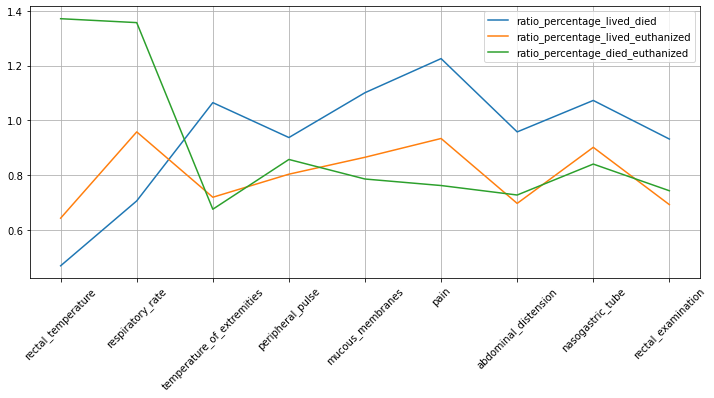

In [9]:
def create_ratio_between_classes(df, label_classes):
    for label_a, label_b in combinations(label_classes, 2):
        df[f"ratio_percentage_{label_a}_{label_b}"] = (
            df[f"{label_a}_percentage_na"] / df[f"{label_b}_percentage_na"]
        )
    col_ratio = [col for col in df.columns if "ratio_percentage" in col]
    return df[col_ratio]


create_ratio_between_classes(df_sum_min_na, df_labels_counts.index).plot(
    figsize=(12, 5), rot=45, grid=True
);

Values closer to 1 have similar percentage of `NaN`s, whereas values that are further away a higher distributions of the `NaN`s across the classification field.  

We can set a lower and upper threshold for filtering out the problematic features. Once all the ratios are between these limits we will want to keep this feature. Any value outside these limits we can assume that the `NaN`s are unevenly distributed, and the features should be removed. 

In [10]:
def get_features_outside_threshold(
    df,
    lt_ratio_threshold=0.7,
    gt_ratio_threshold=1.3,
):
    features_to_drop = []
    for col in [col for col in df.columns if "ratio" in col]:
        mask_ratio_threshold = ~(
            df[col].between(lt_ratio_threshold, gt_ratio_threshold)
        )
        features_to_drop.extend(mask_ratio_threshold[mask_ratio_threshold].index)
    features_to_drop = list(set(features_to_drop))
    return features_to_drop


features_to_drop = get_features_outside_threshold(df_sum_min_na)
features_to_drop

['rectal_examination',
 'abdominal_distension',
 'rectal_temperature',
 'temperature_of_extremities',
 'respiratory_rate']

In [11]:
df_for_model = df_nzr_threshold.drop(columns=features_to_drop)
print(
    f"After removing the features from get_features_outside_threshold function we are left with {number_of_features_with_NaN(df_for_model)} features with `NaN`s that we are going to imputate"
)

After removing the features from get_features_outside_threshold function we are left with 9 features with `NaN`s that we are going to imputate


# Summary  

This post describes the issues while analysing `NaN`s for feature selection.  

Simple filtering methods do not always perform as expected and additional emphsesis should be taken when working with sparse matrices.

We can analyse `NaN` within features in multiple levels:  
1. At the global level - i.e. the total amount of NaNs within a feature  (both for removing and for keeping features) 
2. At the label/classification level - i.e. the relative distribution of NaNs per class.

Finally we recommand trying out the [missingno package](https://github.com/ResidentMario/missingno) for graphical analysis of `NaN` values
